# LAB 5: Text classification with Naive Bayes

## Part 2: Multinomial NB Model

Objectives:

* Train and evaluate Naive Bayes text classifiers
* Cross-validation
* Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and preprocess data

In [2]:
df = pd.read_parquet(
    "s3://ling583/rcv1-politics.parquet", storage_options={"anon": True}
)

In [3]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [4]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [5]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/60509 [00:00<?, ?it/s]

----

### Multinomial Naive Bayes

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

Set up a pipeline: first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [8]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [9]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.99      0.90      0.95     56243
        True       0.41      0.92      0.57      4266

    accuracy                           0.90     60509
   macro avg       0.70      0.91      0.76     60509
weighted avg       0.95      0.90      0.92     60509



---

### Hyperparameter search

In [10]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38985")
client

Client Scheduler: tcp://127.0.0.1:38985 Dashboard: http://127.0.0.1:38309/status,Cluster Workers: 4 Cores: 4 Memory: 16.67 GB


In [11]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [12]:
# Use this to avoid all the warnings
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [13]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

Setup a search to try out a classfier for lots of different parameter values: alpha parameter and optimize f1 score

In [14]:
%%time

search = RandomizedSearchCV(
    mnb, {"multinomialnb__alpha": loguniform(1e-10, 10.0)}, n_iter=25, scoring="f1"
)
search.fit(df["tokens"], df["pol"])  #tokenized data as input, and politics as the labels

CPU times: user 17.6 s, sys: 2.08 s, total: 19.6 s
Wall time: 2min 2s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f02b69c02b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01d7ec9b80>},
                   scoring='f1')

In [15]:
search.best_params_

{'multinomialnb__alpha': 5.187825079211415}

In [16]:
search.best_score_

0.6667223326366691

In [17]:
cv_results = pd.DataFrame(search.cv_results_)

In [18]:
cv_results.head()

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_multinomialnb__alpha
0,{'multinomialnb__alpha': 1.1893829394190624e-08},9.354947,2.847347,3.558992,0.327630,0.648680,0.648571,0.637194,0.644815,0.005389,4,0.0
1,{'multinomialnb__alpha': 0.00013099023841028196},9.346151,2.826442,3.524555,0.227285,0.634159,0.626761,0.627066,0.629328,0.003418,18,0.000131
2,{'multinomialnb__alpha': 0.0005009272701939835},9.373502,2.777996,3.519175,0.088264,0.627432,0.619421,0.622623,0.623159,0.003292,20,0.000501
3,{'multinomialnb__alpha': 2.6621014522772623e-06},9.331266,2.803180,3.491973,0.135165,0.643516,0.640407,0.634335,0.639419,0.003813,8,0.000003
4,{'multinomialnb__alpha': 0.06792809173793204},9.382311,2.818045,3.006198,0.379787,0.581238,0.580589,0.575758,0.579195,0.002445,24,0.067928


<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

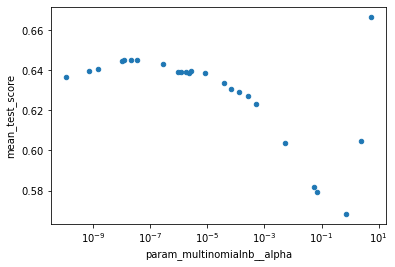

In [19]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

We can see that as alpha gets bigger, the results get worse.  However, we do have 1 value with a high mean test score near value 10.  First, we will explore values between 1e-9 and 1e-7 before looking at value 10.

Now, we exclude words that are very frequent and infrequent.  We will experiment with the threshold levels.

In [20]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 5),  # we will try 1, 2, 3, 4
        "multinomialnb__alpha": loguniform(1e-9, 1e-7),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 17.7 s, sys: 1.92 s, total: 19.6 s
Wall time: 2min 22s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f02b69c02b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01d58cc8e0>,
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01d589ab20>},
                   scoring='f1')

In [21]:
search.best_params_, search.best_score_

({'countvectorizer__min_df': 1, 'multinomialnb__alpha': 3.25831536320573e-08},
 0.6446826423068446)

In [22]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

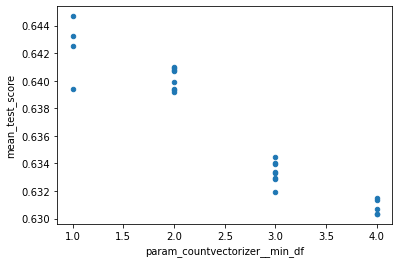

In [23]:
cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

Optimal min_df value is at 1.0

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

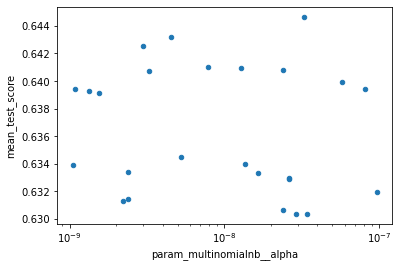

In [24]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

Optimal alpha value is between 1e-8 and 1e-7

cv_results.plot(
    "param_multinomialnb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

Given the graph, we want alpha just under 1e-8 but greater than 1e-7, and min_df = 1.  Let's find max_df which are the terms that are the most frequent.  We filter out the high frequency terms, but KEEP the low frequency terms.

In [26]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": [1],
        "countvectorizer__max_df": uniform(0.5, 0.5), # probably between 0.5 and 1, so we try 0.5 and evaluate. This will give random numbers between 0.5 and 1.
        "multinomialnb__alpha": loguniform(1e-8, 1e-7),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 17.9 s, sys: 2.01 s, total: 20 s
Wall time: 4min 32s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f02b69c02b0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01d4af0b80>,
                                        'countvectorizer__min_df': [1],
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01d4af99d0>},
                   scoring='f1')

In [27]:
search.best_params_, search.best_score_

({'countvectorizer__max_df': 0.8291284078093901,
  'countvectorizer__min_df': 1,
  'multinomialnb__alpha': 1.7572019780112487e-08},
 0.6454347855109706)

<AxesSubplot:xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

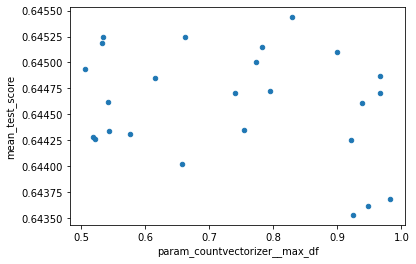

In [28]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

---

### Evaluate final model

In [31]:
mnb.set_params(
    multinomialnb__alpha=1.7572019780112487e-08, countvectorizer__min_df=2, countvectorizer__max_df=0.8291284078093901
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7f02b69c02b0>,
                                 max_df=0.8291284078093901, min_df=2)),
                ('multinomialnb', MultinomialNB(alpha=1.7572019780112487e-08))])

In [32]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.99      0.94      0.96     56243
        True       0.52      0.82      0.64      4266

    accuracy                           0.93     60509
   macro avg       0.75      0.88      0.80     60509
weighted avg       0.95      0.93      0.94     60509



For this model, F1 score is at 0.64 with precision and recall at values 0.52 and 0.82.  This is much better, but precision and recall are not as balanced as we would like.  We will now explore another model possibility with alpha at value 10 (as mentioned above).  For this, please refer to file:  3-multinomial.ipynb.